# Lyric Logic NLP Project

#### Mohamed Youssef - 211001821


## Index

-   [Including Necessary Libraries](#libs)
    <br>
-   [Other Utilites](#uti)
    <br>
-   [Loading the Data](#dataset)
    <br>
-   [Cleaning the Data](#clean)
    <br>
-   [Data Visualization](#vis)
    <br>
-   [Preprocessing the Data](#pre)
    <br>
-   [Feature Extraction](#feat)
    <br>
-   [CNN Model](#cnn)
    <br>
-   [LSTM Model](#lstm)


## Including Necessary Libraries<a id='libs'></a>


In [1]:
# Disable warnings (comment this cell to turn on warnings)
import warnings
import logging


def warn(*args, **kwargs):
    pass


warnings.warn = warn
logging.getLogger("tensorflow").disabled = True

In [100]:
import os  # For file operations and paths
import time  # For measuring time taken to run specific cells
import glob  # For getting testing images paths

import chime  # For making a sound when there is an error

import numpy as np  # For dealing with arrays and matrices
import pandas as pd  # For dealing with dataframes

import matplotlib.pyplot as plt  # For plotting images and graphs
from wordcloud import WordCloud  # For plotting word clouds

from nltk.corpus import stopwords  # For removing stopwords
from langdetect import detect  # For detecting the language of a text
from nltk.stem import WordNetLemmatizer  # For lemmatizing words
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenizing text

from sklearn.model_selection import (
    train_test_split,
)  # For splitting the data into training and testing sets
from tensorflow.keras.utils import to_categorical  # For one-hot encoding the labels
from tensorflow.keras.preprocessing.sequence import (
    pad_sequences,
)  # For padding sequences
from tensorflow.keras.initializers import (
    Constant,
)  # For initializing the embedding layer with GloVe embeddings


# For building the model
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    GlobalMaxPooling1D,
    LSTM,
    Embedding,
    Dropout,
)

import tensorflow as tf  # For configuring the GPU

import dill  # For saving the session

## Other Utilites<a id='uti'></a>


In [3]:
# Setting the path to the dataset
DATASET_PATH = "C:\Datasets\Song Lyrics Dataset"
print("Dataset path is: " + DATASET_PATH)

Dataset path is: C:\Datasets\Song Lyrics Dataset


In [4]:
# Configuring the GPU for training the model

gpus = tf.config.list_physical_devices("GPU")  # Getting the list of GPUs available

# If there is a GPU available, then set the GPU to be used for training the model
if gpus:
    print("GPUs Available: ", gpus)

    # If there are two GPUs available, then use the second GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], "GPU")
        tf.config.experimental.set_memory_growth(gpus[1], True)

    # If there is only one GPU available, then use the first GPU
    except:
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)

# If there is no GPU available, then use the CPU
else:
    print("No GPU Available")

No GPU Available


In [5]:
# Initializing chime
chime.theme("sonic")
chime.notify_exceptions()

## Loading the Data <a id='dataset'></a>


In [6]:
# Getting the paths of the CSV files
csv_files_path = DATASET_PATH + "\*.csv"
csv_files = glob.glob(csv_files_path)

In [7]:
print("CSV Files: ", csv_files)

CSV Files:  ['C:\\Datasets\\Song Lyrics Dataset\\ArianaGrande.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Beyonce.csv', 'C:\\Datasets\\Song Lyrics Dataset\\BillieEilish.csv', 'C:\\Datasets\\Song Lyrics Dataset\\BTS.csv', 'C:\\Datasets\\Song Lyrics Dataset\\CardiB.csv', 'C:\\Datasets\\Song Lyrics Dataset\\CharliePuth.csv', 'C:\\Datasets\\Song Lyrics Dataset\\ColdPlay.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Drake.csv', 'C:\\Datasets\\Song Lyrics Dataset\\DuaLipa.csv', 'C:\\Datasets\\Song Lyrics Dataset\\EdSheeran.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Eminem.csv', 'C:\\Datasets\\Song Lyrics Dataset\\JustinBieber.csv', 'C:\\Datasets\\Song Lyrics Dataset\\KatyPerry.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Khalid.csv', 'C:\\Datasets\\Song Lyrics Dataset\\LadyGaga.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Maroon5.csv', 'C:\\Datasets\\Song Lyrics Dataset\\NickiMinaj.csv', 'C:\\Datasets\\Song Lyrics Dataset\\PostMalone.csv', 'C:\\Datasets\\Song Lyrics Dataset\\Rihanna.csv', 'C:\\Datasets\\

In [8]:
# Load the CSV files into a dataframe
df_list = []
for file in csv_files:
    df_list.append(pd.read_csv(file))

In [9]:
# Load the dataframes into a single dataframe
df = pd.concat(df_list, axis=0, ignore_index=True)

In [10]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist,Title,Album,Date,Lyric,Year,Unnamed: 0
5362,Rihanna,ROCKSTAR 101 (Mark Picchiotti Rockin Radio),ROCKSTAR 101: The Remixes,2010-07-13,rihanna got up in the club posted in the back ...,2010.0,394.0
3674,Katy Perry,Rise (Purity Ring Remix),Rise Remixes - EP,2016-08-26,i won't just conform no matter how you shake m...,2016.0,165.0
5098,Rihanna,Let Me,Music of the Sun (UK Edition),2005-08-19,boy let me let me why don't you let me let me ...,2005.0,130.0
1837,Drake,Pistols,NaN,2017-12-25,you say you want me i don't ignore you you sai...,2017.0,206.0
3702,Katy Perry,More Than This Life,NaN,NaN,lyrics for this song have yet to be released p...,NaN,193.0


In [11]:
# Describe the dataframe
df.describe()

,Year,Unnamed: 0
count,4278.000000,5719.000000
mean,2011.837775,175.362476
std,53.725459,121.678762
min,1.000000,0.000000
25%,2010.000000,71.000000
50%,2014.000000,156.000000
75%,2018.000000,263.000000
max,2022.000000,520.000000


In [12]:
# Checking for null values in the training data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6027 entries, 0 to 6026
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Artist      6027 non-null   object 
 1   Title       6027 non-null   object 
 2   Album       4453 non-null   object 
 3   Date        4278 non-null   object 
 4   Lyric       5981 non-null   object 
 5   Year        4278 non-null   float64
 6   Unnamed: 0  5719 non-null   float64
dtypes: float64(2), object(5)
memory usage: 329.7+ KB


In [13]:
# Show the number of null values in each column
df.isnull().sum()

Artist           0
Title            0
Album         1574
Date          1749
Lyric           46
Year          1749
Unnamed: 0     308
dtype: int64

In [14]:
# Show the names and the count of the unique artists in the dataset
df["Artist"].value_counts()

Artist
Eminem           521
Taylor Swift     479
Drake            466
Beyoncé          406
Rihanna          405
Lady Gaga        402
Justin Bieber    348
Coldplay         344
Katy Perry       325
Nicki Minaj      323
Ariana Grande    308
Ed Sheeran       296
BTS (방탄소년단)      278
Dua Lipa         247
Maroon 5         197
Selena Gomez     175
Post Malone      148
Billie Eilish    145
Charlie Puth      75
Cardi B           75
Khalid            64
Name: count, dtype: int64

In [15]:
# Display the lyrics of the first song in the dataset
df["Lyric"][0]

"thought i'd end up with sean but he wasn't a match wrote some songs about ricky now i listen and laugh even almost got married and for pete i'm so thankful wish i could say thank you to malcolm 'cause he was an angel  pre one taught me love one taught me patience and one taught me pain now i'm so amazing say i've loved and i've lost but that's not what i see so look what i got look what you taught me and for that i say   thank you next next thank you next next thank you next i'm so fuckin' grateful for my ex thank you next next thank you next next thank you next next i'm so fuckin'   spend more time with my friends i ain't worried 'bout nothin' plus i met someone else we havin' better discussions i know they say i move on too fast but this one gon' last 'cause her name is ari and i'm so good with that so good with that  pre she taught me love love she taught me patience patience how she handles pain pain that shit's amazing yeah she's amazing i've loved and i've lost yeah yeah but tha

## Clean the Data <a id='clean'></a>


In [16]:
# Remove unnecessary columns from the dataframe
df = df.drop(columns=["Album", "Date", "Unnamed: 0"])

In [17]:
# Rename the columns to more descriptive names
df.rename(
    columns={
        "Artist": "Artist Name",
        "Title": "Song Title",
        "Year": "Release Year",
        "Lyric": "Song Lyrics",
    },
    inplace=True,
)

In [18]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year
1478,Coldplay,What a Wonderful World,i see trees that are green red roses too i wat...,NaN
2852,Eminem,Lose Yourself (Original Demo Version),yo if you could just for one minute or one spl...,2014.0
1992,Drake,Share,hook x take what you want take what you want t...,2007.0
2898,Eminem,Microphone Freestyle,once again it's the sinister cynical minister ...,NaN
1594,Coldplay,"Oceans - live at e-werk, cologne",wait for your call love the call never came re...,NaN


In [19]:
# Remove rows where lyrics is null
df = df.dropna(subset=["Song Lyrics"])

In [20]:
# Remove any duplicate rows
df = df.drop_duplicates()

In [21]:
# Show the number of null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5981 entries, 0 to 6026
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Artist Name   5981 non-null   object 
 1   Song Title    5981 non-null   object 
 2   Song Lyrics   5981 non-null   object 
 3   Release Year  4247 non-null   float64
dtypes: float64(1), object(3)
memory usage: 233.6+ KB


In [22]:
# Remove rows containing artists with less than 200 songs
df = df.groupby("Artist Name").filter(lambda x: len(x) > 200)

In [23]:
# Remove BTS from the dataset, (since I am not a fan of their music)
df = df[df["Artist Name"] != "BTS (방탄소년단)"]

In [24]:
# Show the names and the count of the unique artists in the dataset
df["Artist Name"].value_counts()

Artist Name
Eminem           521
Taylor Swift     477
Drake            464
Beyoncé          406
Rihanna          397
Lady Gaga        395
Justin Bieber    347
Coldplay         333
Katy Perry       324
Nicki Minaj      321
Ariana Grande    308
Ed Sheeran       294
Dua Lipa         246
Name: count, dtype: int64

In [25]:
# Show the release years and their counts
df["Release Year"].value_counts()

Release Year
2020.0    319
2011.0    289
2017.0    237
2019.0    234
2010.0    219
2009.0    209
2013.0    204
2016.0    198
2018.0    196
2014.0    177
2008.0    154
2015.0    150
2012.0    148
2007.0    123
2006.0    111
2002.0     59
2005.0     51
2003.0     50
2000.0     46
1999.0     36
2001.0     24
2021.0     23
2004.0     22
1998.0     13
1996.0     13
1997.0     10
1.0         3
1988.0      2
1990.0      2
2022.0      2
1729.0      1
1993.0      1
1982.0      1
Name: count, dtype: int64

In [26]:
# Remove any rows where the release year is less than 2000
df = df[df["Release Year"] >= 2000]

In [27]:
# Predict the missing values in the release year column using interpolation
df = df.interpolate(method="linear")

In [28]:
# Change the datatype of the release year to integer
df["Release Year"] = df["Release Year"].astype(int)

In [29]:
# Reset the index of the dataframe
df = df.reset_index(drop=True)

In [30]:
# Show the number of null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Artist Name   3245 non-null   object
 1   Song Title    3245 non-null   object
 2   Song Lyrics   3245 non-null   object
 3   Release Year  3245 non-null   int32 
dtypes: int32(1), object(3)
memory usage: 88.9+ KB


In [31]:
# Describe the dataframe
df.describe()

,Release Year
count,3245.000000
mean,2012.905393
std,5.138704
min,2000.000000
25%,2009.000000
50%,2013.000000
75%,2017.000000
max,2022.000000


In [32]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year
3157,Taylor Swift,Long Live Speeches,north america leg one5808 glendale az 508 sa...,2018
1196,Dua Lipa,Break My Heart (Moon Boots Remix),pre centre of attention you know you can get w...,2020
3116,Taylor Swift,Treacherous (Original Demo Recording),put your lips close to mine as long as they do...,2012
120,Ariana Grande,The Way (Spanglish Version) [feat. J Balvin],letra de the way spanglish version ft j balvin...,2013
1046,Drake,Alton Sterling Statement,i am grateful to be able to call america my se...,2016


## Data Visualization <a id="vis"></a>


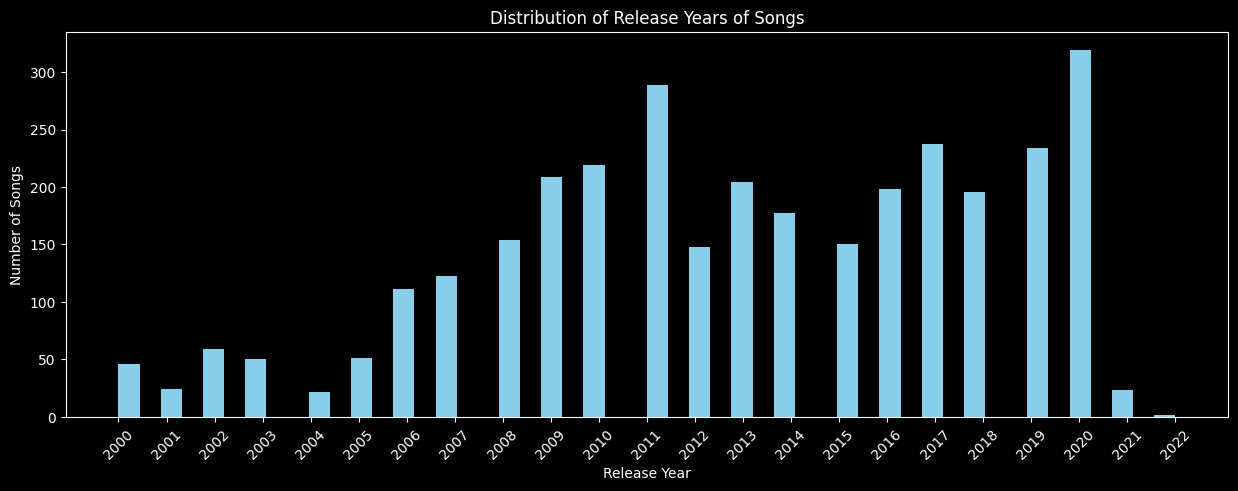

In [33]:
# Visualize the distribution of the release years of the songs
plt.figure(figsize=(15, 5))
plt.hist(df["Release Year"], bins=50, color="skyblue")
plt.xlabel("Release Year")
plt.ylabel("Number of Songs")
plt.xticks(
    np.arange(df["Release Year"].min(), df["Release Year"].max() + 1), rotation=45
)
plt.title("Distribution of Release Years of Songs")
plt.show()

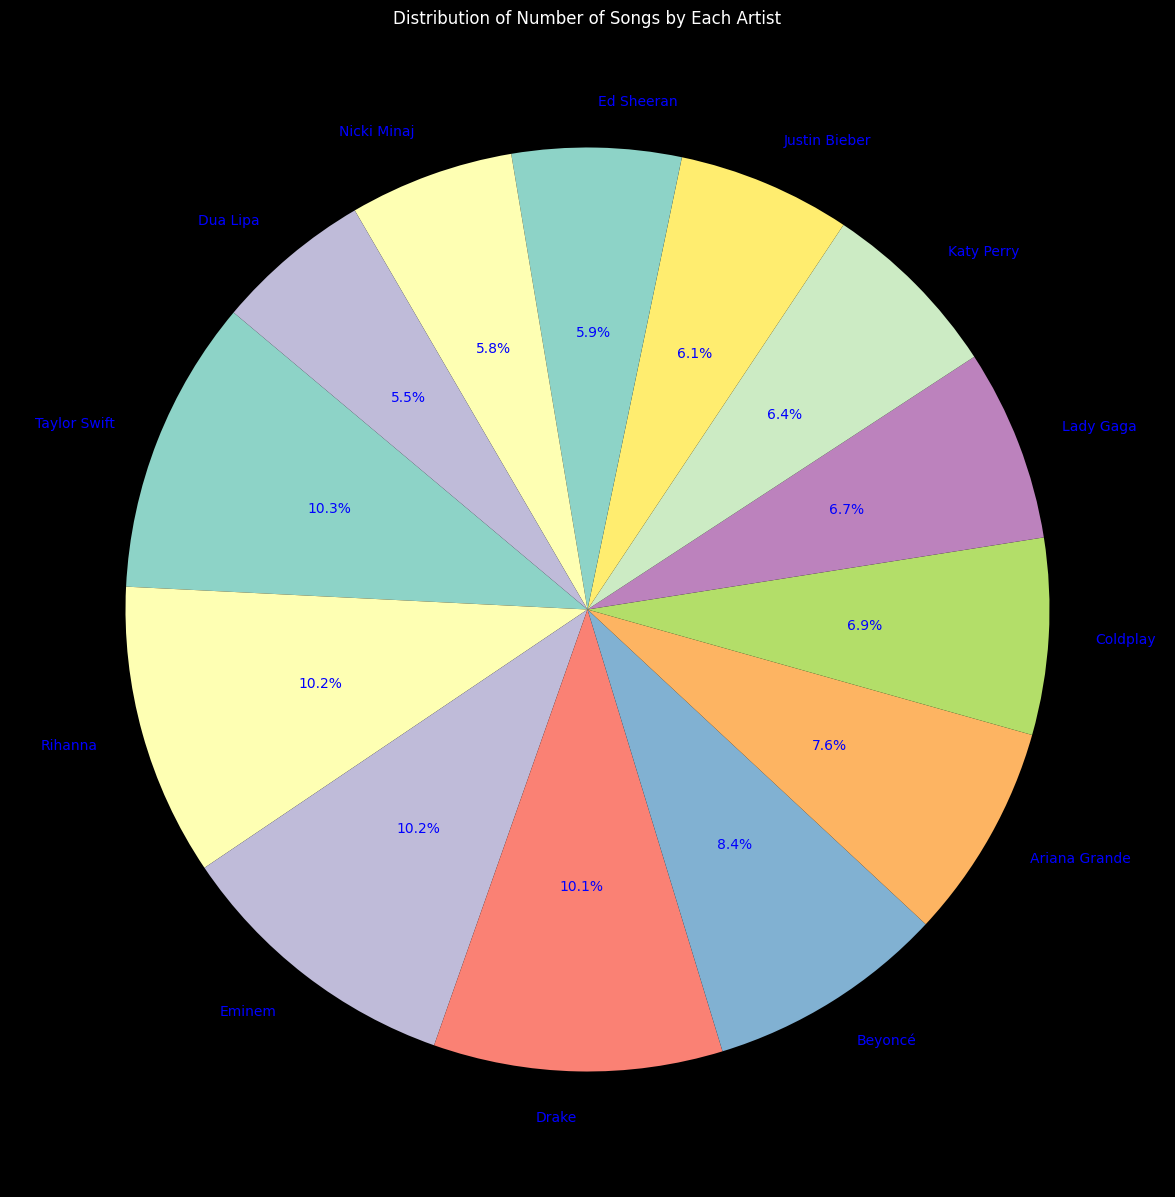

In [34]:
# Visualize the distribution of the number of songs by each artist
plt.figure(figsize=(15, 15))
df["Artist Name"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=140, textprops={"color": "b"}
)
plt.title("Distribution of Number of Songs by Each Artist")
plt.ylabel("")
plt.show()

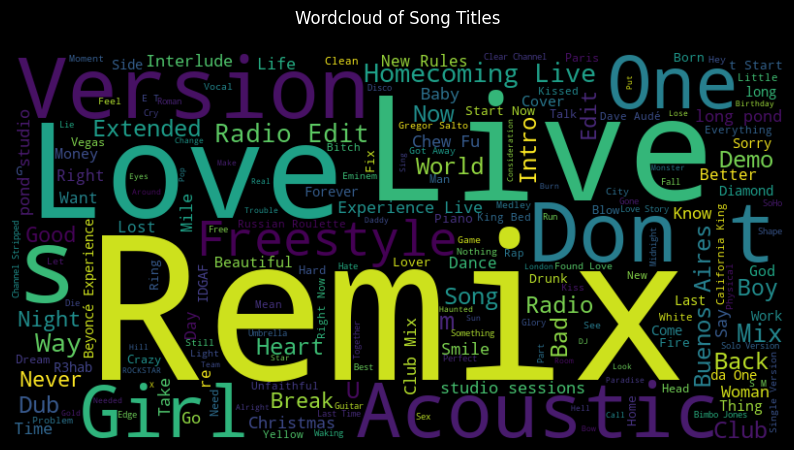

In [35]:
# Visualize words used in song titles using a wordcloud

# Get the song titles
song_titles = " ".join(df["Song Title"].values)

# Create a wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(
    song_titles
)

# Display the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Song Titles\n")
plt.show()

## Preprocessing the Data <a id='pre'></a>


In [36]:
# Create a new column for the preprocsesed lyrics and convert the lyrics to lowercase
df["Processed Lyrics"] = df["Song Lyrics"].apply(lambda x: x.lower())

In [37]:
# Display the lyrics of the first song in the dataset
df["Processed Lyrics"][0]

"thought i'd end up with sean but he wasn't a match wrote some songs about ricky now i listen and laugh even almost got married and for pete i'm so thankful wish i could say thank you to malcolm 'cause he was an angel  pre one taught me love one taught me patience and one taught me pain now i'm so amazing say i've loved and i've lost but that's not what i see so look what i got look what you taught me and for that i say   thank you next next thank you next next thank you next i'm so fuckin' grateful for my ex thank you next next thank you next next thank you next next i'm so fuckin'   spend more time with my friends i ain't worried 'bout nothin' plus i met someone else we havin' better discussions i know they say i move on too fast but this one gon' last 'cause her name is ari and i'm so good with that so good with that  pre she taught me love love she taught me patience patience how she handles pain pain that shit's amazing yeah she's amazing i've loved and i've lost yeah yeah but tha

In [38]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year,Processed Lyrics
715,Coldplay,Cry Cry Cry (Reimagined),chris martin cry cry cry baby cry cry cry chr...,2020,chris martin cry cry cry baby cry cry cry chr...
2630,Rihanna,You Da One,you da one that i dream about all day you da o...,2011,you da one that i dream about all day you da o...
2771,Rihanna,Umbrella (Seamus Haji & Paul Emanuel Club Remix),w background vocals rihanna you have my hear...,2007,w background vocals rihanna you have my hear...
2263,Lady Gaga,Black Jesus + Amen Fashion,black black black black black black black blac...,2011,black black black black black black black blac...
1658,Eminem,Hell Breaks Loose,eminem i want you to understand something that...,2009,eminem i want you to understand something that...


In [39]:
# Remove punctuation from the lyrics
punctuation = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"

df["Processed Lyrics"] = df["Processed Lyrics"].apply(
    lambda x: "".join([l for l in x if l not in punctuation])
)

In [40]:
# Remove any special characters from the lyrics
df["Processed Lyrics"] = df["Processed Lyrics"].str.replace(r"[^a-zA-Z0-9 ]", "")

In [41]:
# Display the lyrics of the first song in the dataset
df["Processed Lyrics"][0]

'thought id end up with sean but he wasnt a match wrote some songs about ricky now i listen and laugh even almost got married and for pete im so thankful wish i could say thank you to malcolm cause he was an angel  pre one taught me love one taught me patience and one taught me pain now im so amazing say ive loved and ive lost but thats not what i see so look what i got look what you taught me and for that i say   thank you next next thank you next next thank you next im so fuckin grateful for my ex thank you next next thank you next next thank you next next im so fuckin   spend more time with my friends i aint worried bout nothin plus i met someone else we havin better discussions i know they say i move on too fast but this one gon last cause her name is ari and im so good with that so good with that  pre she taught me love love she taught me patience patience how she handles pain pain that shits amazing yeah shes amazing ive loved and ive lost yeah yeah but thats not what i see yeah 

In [42]:
# Remove stopwords from the lyrics
stop_words = set(stopwords.words("english"))

df["Processed Lyrics"] = df["Processed Lyrics"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)

In [43]:
# Display the lyrics of the first song in the dataset
df["Processed Lyrics"][0]

'thought id end sean wasnt match wrote songs ricky listen laugh even almost got married pete im thankful wish could say thank malcolm cause angel pre one taught love one taught patience one taught pain im amazing say ive loved ive lost thats see look got look taught say thank next next thank next next thank next im fuckin grateful ex thank next next thank next next thank next next im fuckin spend time friends aint worried bout nothin plus met someone else havin better discussions know say move fast one gon last cause name ari im good good pre taught love love taught patience patience handles pain pain shits amazing yeah shes amazing ive loved ive lost yeah yeah thats see yeah yeah cause look ive found yeah yeah aint need searching say thank next thank next thank next thank next thank next thank im fuckin grateful ex thank next thank next thank next said thank next thank next next im fuckin grateful ex post thank next thank next thank next im fuckin one day ill walk aisle holding hands 

In [44]:
# Remove any extra spaces from the lyrics
df["Processed Lyrics"] = df["Processed Lyrics"].apply(lambda x: " ".join(x.split()))

In [45]:
# Set any processed lyrics value to null if the language isn't english
i = 0


def detect_language(text):
    global i
    print("Processing row: ", i, end="\r")
    i += 1

    try:
        if detect(text) == "en":
            return text
        else:
            return None
    except:
        return None


df["Processed Lyrics"] = df["Processed Lyrics"].apply(detect_language)

In [46]:
# Remove any rows where the processed lyrics is null
df = df.dropna(subset=["Processed Lyrics"])
df.reset_index(drop=True, inplace=True)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3148 entries, 0 to 3147
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Artist Name       3148 non-null   object
 1   Song Title        3148 non-null   object
 2   Song Lyrics       3148 non-null   object
 3   Release Year      3148 non-null   int32 
 4   Processed Lyrics  3148 non-null   object
dtypes: int32(1), object(4)
memory usage: 110.8+ KB


In [48]:
# Perform text lemmatization on the lyrics
lemmatizer = WordNetLemmatizer()

df["Processed Lyrics"] = df["Processed Lyrics"].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
)

In [49]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year,Processed Lyrics
2264,Lady Gaga,Fashion of His Love (Fernando Garibay Remix),loving him the fashion of his loving him the f...,2011,loving fashion loving fashion loving fashion l...
921,Drake,Unstoppable,drake my name is drizzy and i ain't perfect bu...,2009,drake name drizzy aint perfect work hard deser...
1028,Drake,MSG Freestyle (Hot 97),they tellin' lies on hot 97 that's how it goes...,2016,tellin lie hot 97 thats go told em fire funk f...
2501,Rihanna,Diamonds,shine bright like a diamond shine bright like ...,2012,shine bright like diamond shine bright like di...
1455,Eminem,Brainless,or eminem has a full line of chainsaws eminem ...,2013,eminem full line chainsaw eminem eminem eminem...


In [50]:
# Show the number of words in the lyrics of the first song in the dataset
print(
    "Number of words in the processed lyrics of the first song: ",
    len(df["Processed Lyrics"][0].split()),
)

print(
    "Original number of words in the lyrics of the first song: ",
    len(df["Song Lyrics"][0].split()),
)

Number of words in the processed lyrics of the first song:  290
Original number of words in the lyrics of the first song:  463


In [51]:
# Map the artist names to integers
artist_names = df["Artist Name"].unique()
artist_names_map = {artist: i for i, artist in enumerate(artist_names)}
df["Artist Name Map"] = df["Artist Name"].map(artist_names_map)

In [52]:
# Show the number of artists in the dataset
number_of_artists = len(artist_names)
number_of_artists

13

In [53]:
# Show 5 random rows from the dataframe
df.sample(5)

,Artist Name,Song Title,Song Lyrics,Release Year,Processed Lyrics,Artist Name Map
75,Ariana Grande,7 rings (Remix),ariana grande yeah breakfast at tiffany's and ...,2019,ariana grande yeah breakfast tiffany bottle bu...,0
1228,Ed Sheeran,Save Myself,i gave all my oxygen to people that could brea...,2017,gave oxygen people could breathe gave away mon...,5
2554,Rihanna,SOS,lalala lalala lalalalala oh you know i've neve...,2006,lalala lalala lalalalala oh know ive never fel...,11
2004,Katy Perry,Search Me,through this skin you see my heart through thi...,2001,skin see heart laughter feel pain even mask se...,8
2593,Rihanna,Lemme Get That,refrain rihanna i got a house but i need new f...,2007,refrain rihanna got house need new furniture s...,11


In [54]:
# Split the dataset into target and features
X = df["Processed Lyrics"]
y = df["Artist Name Map"]

In [55]:
MAX_NUM_WORDS = 15000  # Maximum number of words to be used in the tokenizer
EMBEDDING_DIM = 200  # Dimension of the word embeddings
TEST_AND_VALIDATION_SPLIT = (
    0.2  # Percentage of the data to be used for testing and validation
)
max_sequence_length = max([len(x.split()) for x in X]) + 1  # Maximum sequence length
max_sequence_length

3134

In [56]:
# One hot encode the target variable
y = to_categorical(np.asarray(y))

In [57]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_AND_VALIDATION_SPLIT, random_state=420
)

In [58]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (2518,)
Shape of X_test:  (630,)
Shape of y_train:  (2518, 13)
Shape of y_test:  (630, 13)


In [59]:
# Tokenize the text data
tokenizer = Tokenizer(
    num_words=MAX_NUM_WORDS
)  # Setting the maximum number of words to be used in the tokenizer
tokenizer.fit_on_texts(X_train)  # Fitting the tokenizer on the training data
train_sequences = tokenizer.texts_to_sequences(
    X_train
)  # Converting the training data to sequences
test_sequences = tokenizer.texts_to_sequences(
    X_test
)  # Converting the testing data to sequences

word_index = tokenizer.word_index  # Getting the word index
print("Number of unique words: ", len(word_index))

Number of unique words:  22842


In [60]:
print(X_train[0])
print(train_sequences[0])

thought id end sean wasnt match wrote song ricky listen laugh even almost got married pete im thankful wish could say thank malcolm cause angel pre one taught love one taught patience one taught pain im amazing say ive loved ive lost thats see look got look taught say thank next next thank next next thank next im fuckin grateful ex thank next next thank next next thank next next im fuckin spend time friend aint worried bout nothin plus met someone else havin better discussion know say move fast one gon last cause name ari im good good pre taught love love taught patience patience handle pain pain shit amazing yeah shes amazing ive loved ive lost yeah yeah thats see yeah yeah cause look ive found yeah yeah aint need searching say thank next thank next thank next thank next thank next thank im fuckin grateful ex thank next thank next thank next said thank next thank next next im fuckin grateful ex post thank next thank next thank next im fuckin one day ill walk aisle holding hand mama il

In [61]:
# Pad the sequences
X_train = pad_sequences(train_sequences, maxlen=max_sequence_length)
X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [62]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=TEST_AND_VALIDATION_SPLIT, random_state=420
)

In [63]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (2014, 3134)
Shape of X_val:  (504, 3134)
Shape of X_test:  (630, 3134)
Shape of y_train:  (2014, 13)
Shape of y_val:  (504, 13)
Shape of y_test:  (630, 13)


## Feature Extraction <a id='feat'></a>

In [64]:
# Setting the glove directory path
GLOVE_PATH = "C:\Datasets\glove.6B"

In [65]:
# Load the GloVe word embeddings into a dictionary

embeddings_index = {}  # Initialize the embeddings index dictionary

# Open the GloVe word embeddings file
with open(os.path.join(GLOVE_PATH, "glove.6B.200d.txt"), encoding="utf8") as f:

    # Loop through each line in the file
    for line in f:
        values = line.split()  # Split the line by spaces
        word = values[0]  # Get the word
        coefs = np.asarray(values[1:], dtype="float32")  # Get the coefficients
        embeddings_index[word] = (
            coefs  # Add the word and its coefficients to the dictionary
        )

In [66]:
print("Found %s word vectors in Glove embeddings." % len(embeddings_index))
print("Embedding for the word 'love':")
print(embeddings_index["love"])

Found 400000 word vectors in Glove embeddings.
Embedding for the word 'love':
[ 3.0443e-01  1.3912e-01 -2.2321e-01  5.5030e-02 -3.9927e-01 -9.1646e-02
 -6.0113e-01  3.1169e-02 -2.0895e-01  5.8123e-01 -3.3094e-01  5.7695e-01
 -3.1589e-01  9.8061e-02 -2.8631e-01  1.2140e-01 -8.4150e-02  7.6244e-01
  5.2208e-01  4.3290e-01  6.8615e-01  1.6706e+00  3.7482e-01 -1.8729e-01
  6.7264e-01 -2.6011e-01  4.2251e-01  2.3638e-01 -2.7498e-01  8.8301e-02
 -3.6438e-01  1.3059e-01  2.6137e-01 -3.4149e-02 -1.8843e-01 -5.1515e-01
 -4.7131e-01 -3.1717e-02  8.1075e-02 -3.1137e-01 -3.7055e-01  1.7943e-01
  8.8090e-04  6.2601e-02 -2.7884e-01  8.3498e-02  6.4031e-01 -3.7709e-01
  4.2937e-01  5.1991e-01 -9.2588e-02 -2.0270e-01 -6.1070e-02  8.0062e-01
  2.1493e-01 -2.0545e-01 -2.0012e-01  1.9416e-01  5.5192e-01 -1.7063e-01
 -3.1811e-01 -2.7010e-01 -5.6274e-01  7.4019e-01 -3.6589e-01 -3.0555e-01
  1.7031e-01  6.5522e-01  4.0899e-01  2.2429e-01  6.3616e-01 -5.9560e-01
  3.8884e-03 -5.1774e-02 -6.4669e-01 -2.8715e-

In [67]:
# Creating the embedding matrix
number_of_words = min(MAX_NUM_WORDS, len(word_index) + 1)  # Number of words
embedding_matrix = np.zeros(
    (number_of_words, EMBEDDING_DIM)
)  # Initialize the embedding matrix
print("The shape of the embedding matrix", embedding_matrix.shape)

The shape of the embedding matrix (15000, 200)


In [68]:
# Fill the embedding matrix with the GloVe embeddings
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [69]:
# Initialize the embedding layer with the GloVe embeddings
embedding_layer = Embedding(
    number_of_words,
    EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_sequence_length,
    trainable=False,
)

In [70]:
# Save the session
# dill.dump_session("Song Lyrics Classification.db")

In [71]:
# Load the session
dill.load_session("Song Lyrics Classification.db")

## CNN Model <a id='cnn'></a>

In [93]:
# Create the first CNN model
cnn_model_1 = Sequential()
cnn_model_1.add(embedding_layer)
cnn_model_1.add(Conv1D(128, 5, activation="relu"))
cnn_model_1.add(MaxPooling1D(5))
cnn_model_1.add(Conv1D(128, 5, activation="relu"))
cnn_model_1.add(MaxPooling1D(5))
cnn_model_1.add(Conv1D(128, 5, activation="relu"))
cnn_model_1.add(GlobalMaxPooling1D())
cnn_model_1.add(Dense(128, activation="relu"))
cnn_model_1.add(Dense(number_of_artists, activation="softmax"))

In [94]:
# Show the model summary
cnn_model_1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 3134, 200)      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [95]:
# Compile the model
cnn_model_1.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [96]:
# Fit the model
start_time = time.time()
history = cnn_model_1.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_val, y_val),
)
end_time = time.time()
print("Time taken to train the model: ", end_time - start_time)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - accuracy: 0.1440 - loss: 2.5169 - val_accuracy: 0.2718 - val_loss: 2.2522
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step - accuracy: 0.2690 - loss: 2.1506 - val_accuracy: 0.3631 - val_loss: 1.9687
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.4102 - loss: 1.7575 - val_accuracy: 0.4087 - val_loss: 1.8571
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.6095 - loss: 1.2134 - val_accuracy: 0.5575 - val_loss: 1.3769
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 415ms/step - accuracy: 0.7550 - loss: 0.7973 - val_accuracy: 0.5992 - val_loss: 1.3304
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 424ms/step - accuracy: 0.8834 - loss: 0.4248 - val_accuracy: 0.6171 - val_loss: 1.4081
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.9256 - loss: 0.2926 - val_accuracy: 0.5913 - val_loss: 1.7291
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - accuracy: 0.9583 - loss: 0.1637 - val_accu

In [97]:
# Evaluate the model
loss, accuracy = cnn_model_1.evaluate(X_test, y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6305 - loss: 1.9336
Test Loss:  1.9001811742782593
Test Accuracy:  0.644444465637207


CNN Model 1 Observation:
-   The model is not generalizing well to the data, as the training accuracy is very high, but the validation accuracy is low.
-   Common reasons for this issue:
    -   The model is overfitting to the training data.
    -   The model is not complex enough to capture the features of the data.
-   Solutions:
    -   Add a dropout layer to the model.
    -   Add more layers to the model.

In [98]:
# Save the model
cnn_model_1.save("Song Lyrics Classification CNN Model 1.h5")

In [101]:
# Create the second CNN model (With Dropout)
cnn_model_2 = Sequential()
cnn_model_2.add(embedding_layer)

cnn_model_2.add(Conv1D(128, 5, activation="relu"))
cnn_model_2.add(Dropout(0.2))
cnn_model_2.add(MaxPooling1D(5))

cnn_model_2.add(Conv1D(128, 5, activation="relu"))
cnn_model_2.add(Dropout(0.2))
cnn_model_2.add(MaxPooling1D(5))

cnn_model_2.add(Conv1D(128, 5, activation="relu"))
cnn_model_2.add(Dropout(0.2))

cnn_model_2.add(GlobalMaxPooling1D())
cnn_model_2.add(Dense(128, activation="relu"))
cnn_model_2.add(Dense(number_of_artists, activation="softmax"))

In [102]:
# Show the model summary
cnn_model_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 3134, 200)      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [103]:
# Compile the model
cnn_model_2.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [104]:
# Fit the model
start_time = time.time()
history = cnn_model_2.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_val, y_val),
)
end_time = time.time()
print("Time taken to train the model: ", end_time - start_time)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 356ms/step - accuracy: 0.0959 - loss: 2.6368 - val_accuracy: 0.2659 - val_loss: 2.3817
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 408ms/step - accuracy: 0.2559 - loss: 2.2522 - val_accuracy: 0.2937 - val_loss: 2.1708
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 464ms/step - accuracy: 0.3718 - loss: 1.8837 - val_accuracy: 0.4325 - val_loss: 1.8364
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 608ms/step - accuracy: 0.4927 - loss: 1.4923 - val_accuracy: 0.4464 - val_loss: 1.7414
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 603ms/step - accuracy: 0.6078 - loss: 1.1623 - val_accuracy: 0.5833 - val_loss: 1.4183
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 547ms/step - accuracy: 0.7435 - loss: 0.8114 - val_accuracy: 0.6171 - val_loss: 1.3014
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.8320 - loss: 0.5489 - val_accuracy: 0.6310 - val_loss: 1.2714
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 551ms/step - accuracy: 0.8689 - loss: 0.3834 - val_accu

In [105]:
# Evaluate the model
loss, accuracy = cnn_model_2.evaluate(X_test, y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6318 - loss: 1.3311
Test Loss:  1.3756920099258423
Test Accuracy:  0.6333333253860474


CNN Model 2 Observation:
-   The model is still not generalizing well.
-   Common reasons for this issue:
    -   The model is overfitting to the training data. ❌
    -   The model is not complex enough to capture the features of the data.
-   Solutions:
    -   Add more layers to the model.
    -   Change the model from CNN to a LSTM or a GRU model.

In [106]:
# Save the model
cnn_model_2.save("Song Lyrics Classification CNN Model 2.h5")

## LSTM Model <a id='lstm'></a>

In [112]:
# Create the first LSTM model
lstm_model_1 = Sequential()
lstm_model_1.add(embedding_layer)
lstm_model_1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model_1.add(Dense(number_of_artists, activation="softmax"))

In [113]:
# Show the model summary
lstm_model_1.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 3134, 200)      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [114]:
# Compile the model
lstm_model_1.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [115]:
# Fit the model
start_time = time.time()
history = lstm_model_1.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_val, y_val),
)
end_time = time.time()
print("Time taken to train the model: ", end_time - start_time)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.1141 - loss: 2.5525 - val_accuracy: 0.1806 - val_loss: 2.4518
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.2344 - loss: 2.3432 - val_accuracy: 0.2302 - val_loss: 2.2896
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3141 - loss: 2.1487 - val_accuracy: 0.3016 - val_loss: 2.1587
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.3767 - loss: 1.9914 - val_accuracy: 0.2937 - val_loss: 2.1218
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.4091 - loss: 1.8763 - val_accuracy: 0.3274 - val_loss: 2.0763
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.4506 - loss: 1.7642 - val_accuracy: 0.3413 - val_loss: 2.0761
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.4920 - loss: 1.6528 - val_accuracy: 0.3552 - val_loss: 1.9253
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5090 - loss: 1.5591 - val_accuracy: 0.3968 - val_loss: